# Utility funtions

In [1]:
%%writefile utils.py
import numpy as np
import json
from typing import *


def softmax(logits: np.ndarray):
    """Compute the softmax of a logits.

    Args:
        logits (np.ndarray): a 1-d array logits

    Returns:
        np.ndarray: probability distribution of the logits using softmax
    """
    exp_logits = np.exp(logits - logits.max())
    return exp_logits / np.sum(exp_logits)


def return_probabilities(state: str, qvalue_state: np.ndarray, kind: str):
    """Generate a probability distribution of actions at a given state, knowing the Q-value

    Args:
        state (str): current state
        qvalue_state (np.ndarray): `1-D`of the Q-value at the given state
        kind (str): one of the strings `'random'`, `'greedy'` or `'softmax'` which will be used to define the probability.

    Raises:
        NotImplementedError: raise Error if kind is not one of `'random'`, `'greedy'` and `'softmax'`

    Returns:
        list: the policy distribution at the given state
    """
    index_state = np.array(list(map(int, list(state))))
    probs = np.zeros_like(qvalue_state, dtype=np.float)
    logits = qvalue_state[index_state == 0]
    if kind == "greedy":
        p = np.zeros_like(logits)
        idx_max = np.where(logits - logits.max() == 0)[0]
        p[idx_max] = 1 / len(
            idx_max
        )  # Give the same probability when there are more than one maximum
    elif kind == "softmax":
        p = softmax(logits)
    elif kind == "random":
        p = 1 / len(logits)
    else:
        raise NotImplementedError
    probs[index_state == 0] = p
    return list(probs)


def generate_json_policy(policy: dict, json_policy_path: str):
    """Generate a json file of the policy dictionary

    Args:
        policy (dict): a policy of an agent
        json_policy_path (str): a path where the json file will be stored
    """
    with open(json_policy_path, "w") as json_file:
        json.dump(policy, json_file, indent=2)


def read_json_policy(json_policy_path: str):
    """Generate a policy in a dictionary from a json file

    Args:
        json_policy_path (str): path where the json file is stored

    Returns:
        dict[str: list]: a policy dictionary with states (`str`) as keys and action distributions (`list`) as values
    """
    with open(json_policy_path, "r") as json_file:
        policy = json.load(json_file)
    return policy


Overwriting utils.py


# Q-Agent class and run episode function

In [2]:
%%writefile q_agent_model.py
import imp
import numpy as np
from typing import *
from utils import return_probabilities, generate_json_policy
from tictactoe import TicTacToe


class Player:
    def __init__(
        self, num_actions: int, gamma: float, learning_rate: float, epsilon: float
    ) -> None:
        """A free tabular Q-agent class for Tic Tac Toe player

        Args:
            num_actions (int): the total number of actions for the environment
            gamma (float): discount factor (between 0 to 1, 1 excluded from theory). The higher gamma is, the more the agent look at a bigger horizon.
            learning_rate (floar): learning rate for update Q-function (from 0 to 1). The higher learning rate is, the higher exploitation.
            epsilon (float): probability of acting non greedily (from 0 to 1). The higher epsilon is, the more the agent explore.
        """
        self.qfunction = {}
        self._gamma = gamma
        self._alpha = learning_rate
        self._epsilon = epsilon
        self._num_actions = num_actions

    def act(self, state: str, eval: bool = False):
        """Sample action at a given state

        Args:
            state (str): state where to chose a sample action according the `qfunction` and the `eval` flag.
            eval (bool, optional): a flag saying wether the sampling should be done greedily (if `eval` is set to `True`) or epsilon-greedy. Defaults to False.

        Returns:
            int: a sample action at the given state.
        """
        if state not in self.qfunction:
            self.qfunction[state] = np.zeros(self._num_actions)
        Q_s = self.qfunction[state]
        value_are_not_the_same = np.any(Q_s - Q_s[0])
        if (eval or np.random.uniform() > self._epsilon) and value_are_not_the_same:
            idx_max = np.arange(self._num_actions)[
                Q_s == Q_s.max()
            ]  # find all indices with max value
            action = np.random.choice(idx_max)  # grab argmax uniformely
        else:
            action = np.random.randint(self._num_actions)
        return action

    def update(
        self, state: str, action: int, next_state: str, reward: int, done: bool
    ) -> None:
        """Update function for the qfunction at a given `state` with a given `action` which takes it to a given state (`next_state`) and obtain a reward `reward` and a flag `done` saying wether the .
        the new state is a terminal sate or not.

        Args:
            state (str): current state
            action (int): action to perfom
            next_state (str): next state after performing the action at the state
            reward (int): reward obtained by performing the action at the state
            done (bool): falg saying wether the next state is a terminal state or not
        """
        if state not in self.qfunction:
            self.qfunction[state] = np.zeros(self._num_actions)

        if done:
            self.qfunction[state][action] = (1 - self._alpha) * self.qfunction[state][
                action
            ] + self._alpha * reward
        else:
            if next_state not in self.qfunction:
                self.qfunction[next_state] = np.zeros(self._num_actions)
            self.qfunction[state][action] = (1 - self._alpha) * self.qfunction[state][
                action
            ] + self._alpha * (reward + self._gamma * self.qfunction[next_state].max())

    def generate_policy(self, kind: str, json_policy_path: str = None):
        """Generate a policy of an agent from its qfunction.

        Args:
            kind (str): one of the strings `'random'`, `'greedy'` or `'softmax'` which will be used to define the probability.
            json_policy_path (str, optional): A path to save the policy as a json file. Defaults to None. If it is none, then the policy will only be returned as a dictionary.

        Returns:
            dict: generated policy
        """
        policy = {}
        for state, qvalue in self.qfunction.items():
            if "0" in state:  # only consider the case that there is an empty slot
                policy[state] = return_probabilities(
                    state=state, qvalue_state=qvalue, kind=kind
                )
        if json_policy_path is not None:
            generate_json_policy(policy, json_policy_path)
        return policy


def run_episode_agent_vs_agent(
    player1: Player,
    player2: Player,
    environment: TicTacToe,
    eval: bool,
    max_step: int = 100,
):
    """Runing episode between two adgents players.

    Args:
        player1 (Player): first Q-agent player
        player2 (Player): second q-agent player
        environment (TicTacToe): the tic tac toe environment where the two agents will play
        eval (bool): flag saying wether it is an evaluation or a training with update. If it is an evaluation, then both player will play greedily.
        max_step (int, optional): maximum step allowed for the episode. Defaults to 100.

    Returns:
        tuple(list[int,int], int): where the list will contain the reward of player1 and player2 respectedly during the episode. The second element is a integer (1 or 2) value of the  winner. It will be 0 if it is a draw.
    """
    state = environment.reset()
    n_steps = 0
    player = [player1, player2]
    rewards = [0, 0]
    dones = [False, False]
    p = 0
    winners = []
    while True:
        action = player[p].act(state, eval=eval)
        next_state, reward, done, switch = environment.step(action)

        if not eval:
            player[p].update(state, action, next_state, reward, done)
        rewards[p] += reward
        dones[p] = done
        if done:
            winners.append(p + 1)
        n_steps += 1
        state = next_state
        if all(dones) or n_steps > max_step:
            break
        if switch:  # do not pass the hand until player put in an empty place
            p = int(not p)
    winner = winners[0] if winners else 0
    return rewards, winner


Overwriting q_agent_model.py


# Import necessary libraries

In [3]:
from tictactoe import TicTacToe
from q_agent_model import Player, run_episode_agent_vs_agent
from utils import generate_json_policy
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Set training hyper-params

In [4]:
gamma=.999 # @param horizon
learning_rate=0.00001 # @param exploitation
epsilon= 1 # @param exploration

In [5]:
num_episodes = 100000 # @param number of episode during training
max_step = 100 # @param maximum number of step in an episode
eval_every_N = 10 # @param evaluation period
num_eval_episodes = 3 # @param number of episode to run in each evaluation

# Train a model

Train two models against each other 

In [6]:
print("Generating TicTacToe environment...")
environment = TicTacToe()
print()
print("Generating Player1 agent...")
player1 = Player(environment.num_actions, gamma=gamma, learning_rate=learning_rate, epsilon= epsilon)
print("Generating Player2 agent...")
player2 = Player(environment.num_actions, gamma=gamma, learning_rate=learning_rate, epsilon= epsilon)

print()
print("-"*10, "BEGIN TRAINING", "-"*10)
all_rewards = []
episodes = []
winners = []
print("\nYou can choose to stop training at any time by interrupting.")
try:
    for episode in tqdm(range(num_episodes)):
        run_episode_agent_vs_agent(player1, player2, environment, eval=False, max_step = max_step)

        if episode % eval_every_N == 0:
            rewards_list = []
            winners_list = [0,0,0]
            for _ in range(num_eval_episodes):
                rewards, winner =run_episode_agent_vs_agent(player1, player2, environment, eval=True, max_step = max_step)
                rewards_list.append(rewards)
                winners_list[winner] += 1
            rewards = np.mean(rewards_list, axis=-1)
            winners.append(winners_list.copy())
            all_rewards.append(rewards)
            episodes.append(episode)
except KeyboardInterrupt:
    pass

all_rewards = np.array(all_rewards).T
winners = np.array(winners).T

print("-"*10, "END TRAINING", "-"*10)


Generating TicTacToe environment...

Generating Player1 agent...
Generating Player2 agent...

---------- BEGIN TRAINING ----------

You can choose to stop training at any time by interrupting.


100%|██████████| 100000/100000 [00:22<00:00, 4443.12it/s]


---------- END TRAINING ----------


# Model visualization

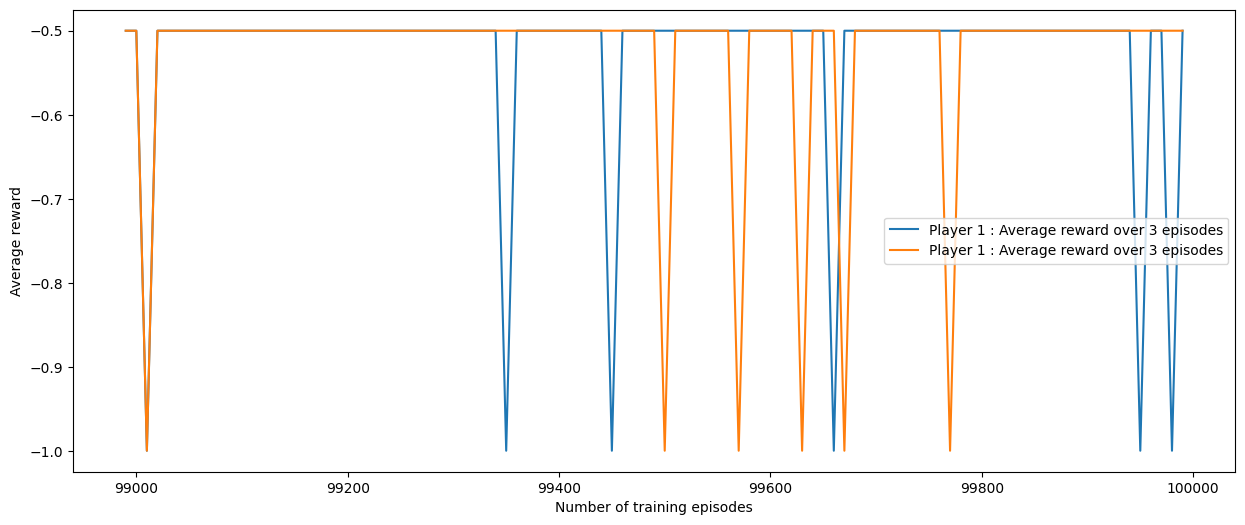

In [7]:
from_index = len(episodes)-1-100
plt.figure(figsize=(15, 6))
plt.xlabel('Number of training episodes')
plt.ylabel('Average reward')
plt.plot(episodes[from_index:], all_rewards[0][from_index:], label=f"Player 1 : Average reward over {num_eval_episodes} episodes")
plt.plot(episodes[from_index:], all_rewards[1][from_index:], label=f"Player 1 : Average reward over {num_eval_episodes} episodes")
plt.legend()

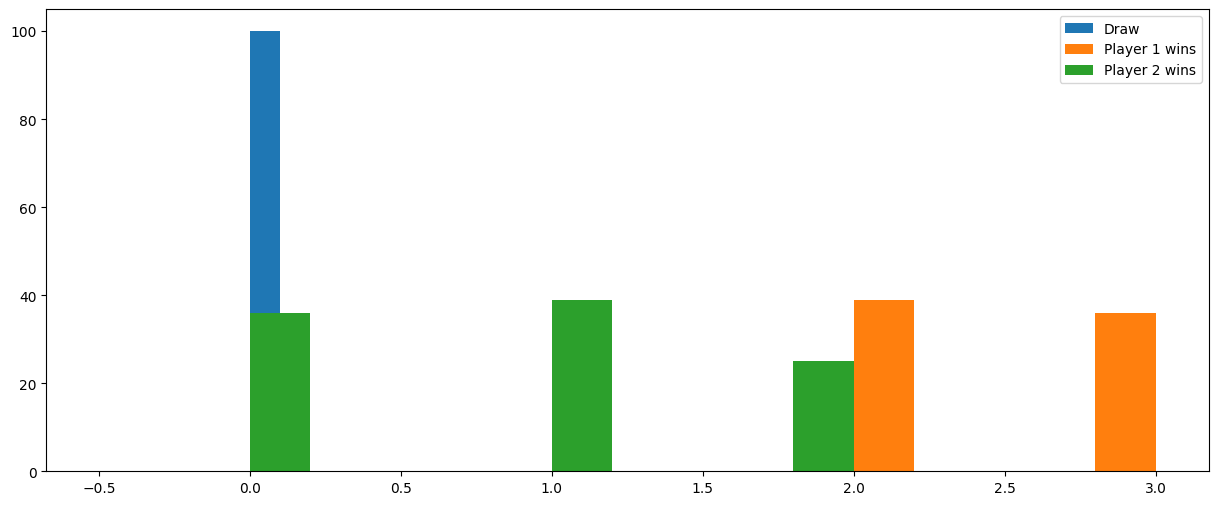

In [8]:
end_index = -1 
plt.figure(figsize=(15, 6))
plt.hist(winners[0][from_index:end_index], label=f"Draw")
plt.hist(winners[1][from_index:end_index], label=f"Player 1 wins")
plt.hist(winners[2][from_index:end_index], label=f"Player 2 wins")
plt.legend()

In [9]:
draw, p1, p2 = np.ceil(np.mean(winners[:,from_index:end_index],axis=-1)*100/num_eval_episodes)
print(f"{draw}% is Draw\n{p1}% Player 1 wins\n{100-draw-p1}% Player 2 wins")

0.0% is Draw
71.0% Player 1 wins
29.0% Player 2 wins


# Generating policies as json files

In [10]:
easy = player1.generate_policy(kind = "random",json_policy_path="json_agents/easy.json")

print("Random policy generated successfully")

Random policy generated successfully


In [11]:
player1.generate_policy(kind = "softmax", json_policy_path = f"json_agents/medium_player1.json")
player2.generate_policy(kind = "softmax", json_policy_path = f"json_agents/medium_player2.json")
print("Medium policy generated successfully")

Medium policy generated successfully


In [12]:
player1.generate_policy(kind = "greedy", json_policy_path = f"json_agents/hard_player1.json")
player2.generate_policy(kind = "greedy", json_policy_path = f"json_agents/hard_player2.json")
print("Hard policy generated successfully")

Hard policy generated successfully
